In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Data Exploration

* Load and examine the dataset.
* Identify missing values and outliers.
* Visualize the data to better understand the relationships and distributions.

In [2]:
#Importing Libraries for data visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Loading Data Files
df_train_cli = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
df_train_pep = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
df_train_pro = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")

In [3]:
df_train_pro.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [4]:
df_train_cli.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [5]:
df_train_pep.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


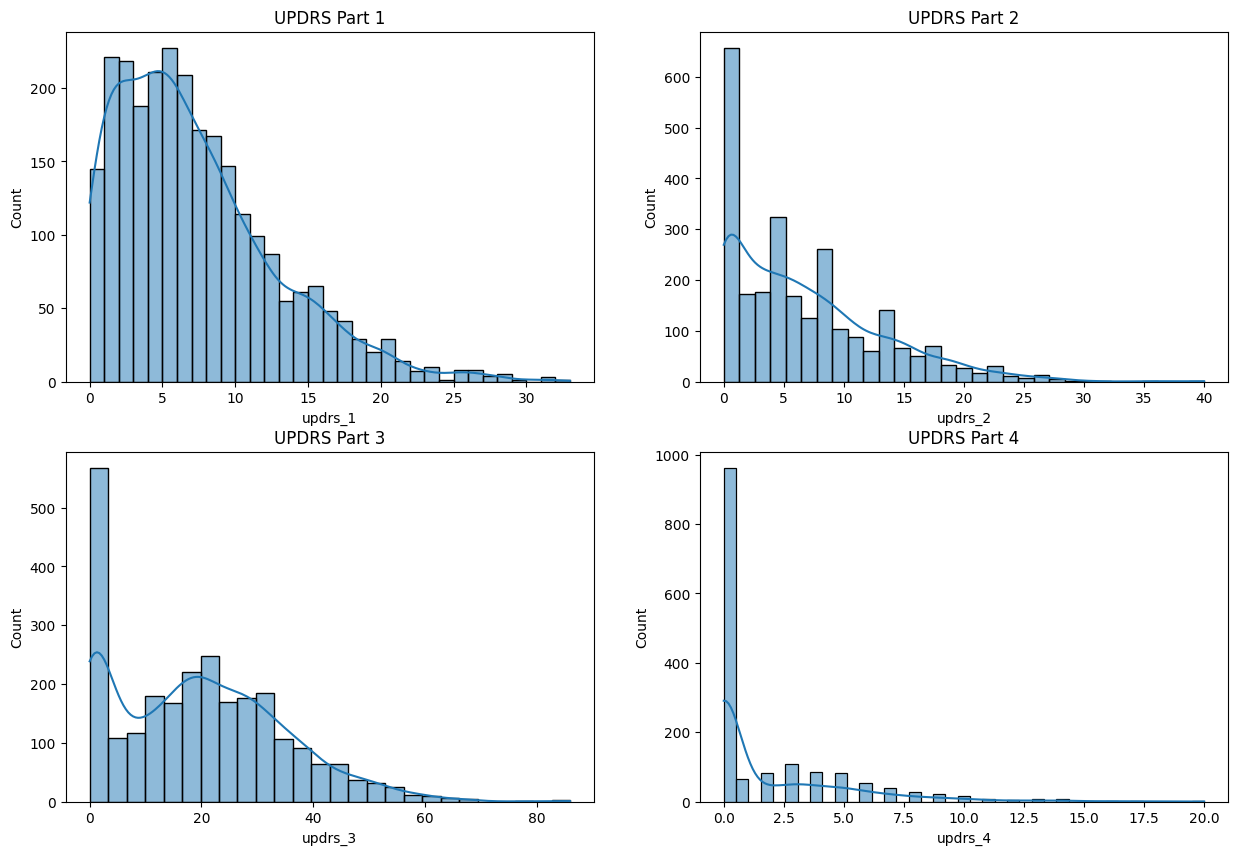

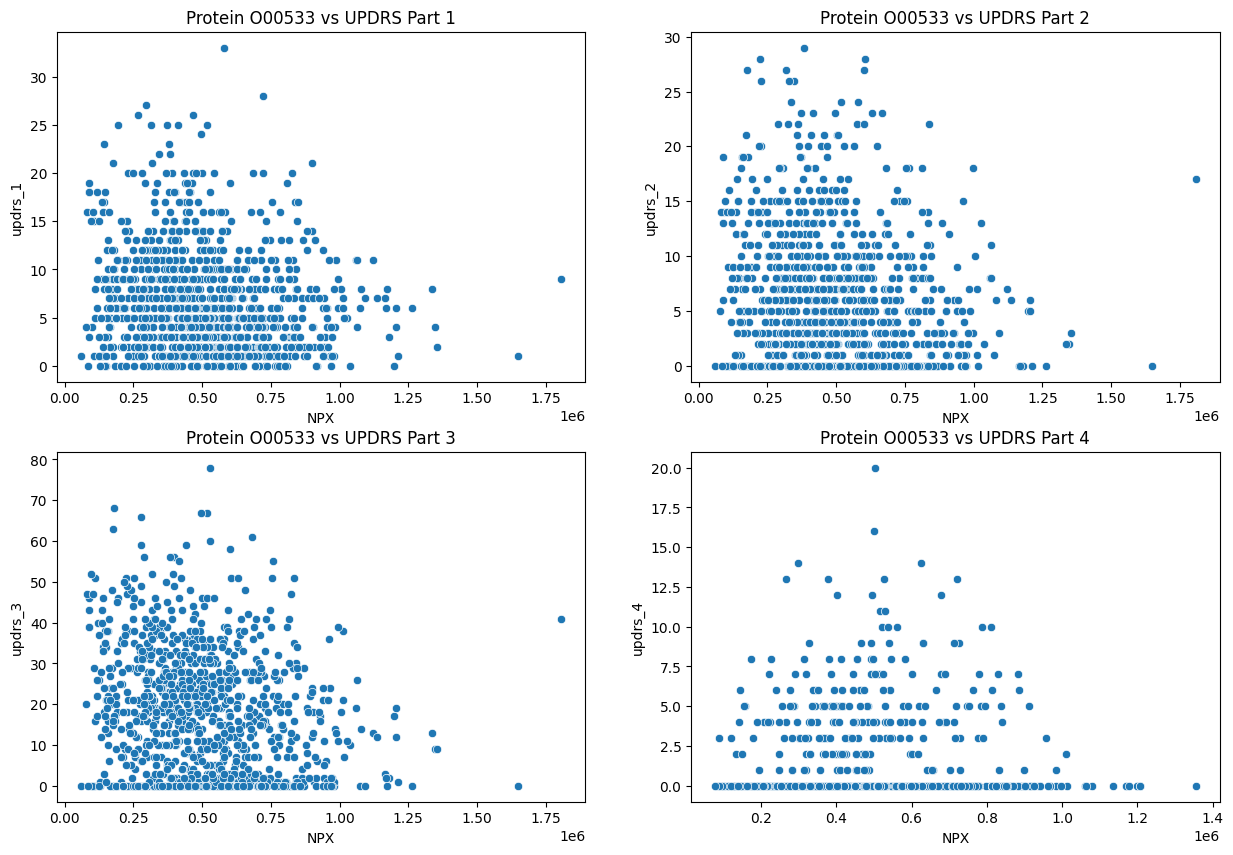

In [6]:
#Visualize distribution of UPDRS Scores in the training data 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_train_cli['updrs_1'], kde=True, ax=axes[0, 0])
sns.histplot(df_train_cli['updrs_2'], kde=True, ax=axes[0, 1])
sns.histplot(df_train_cli['updrs_3'], kde=True, ax=axes[1, 0])
sns.histplot(df_train_cli['updrs_4'], kde=True, ax=axes[1, 1])

axes[0, 0].set_title('UPDRS Part 1')
axes[0, 1].set_title('UPDRS Part 2')
axes[1, 0].set_title('UPDRS Part 3')
axes[1, 1].set_title('UPDRS Part 4')

plt.show()

#Plotting relationship between example proteins and the UPDRS scores

example_protein = 'O00533'
merged_data = df_train_pro.merge(df_train_cli, on=['visit_id', 'visit_month', 'patient_id'])
example_data = merged_data[merged_data['UniProt'] == example_protein]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='NPX', y='updrs_1', data=example_data, ax=axes[0, 0])
sns.scatterplot(x='NPX', y='updrs_2', data=example_data, ax=axes[0, 1])
sns.scatterplot(x='NPX', y='updrs_3', data=example_data, ax=axes[1, 0])
sns.scatterplot(x='NPX', y='updrs_4', data=example_data, ax=axes[1, 1])

axes[0, 0].set_title(f'Protein {example_protein} vs UPDRS Part 1')
axes[0, 1].set_title(f'Protein {example_protein} vs UPDRS Part 2')
axes[1, 0].set_title(f'Protein {example_protein} vs UPDRS Part 3')
axes[1, 1].set_title(f'Protein {example_protein} vs UPDRS Part 4')

plt.show()

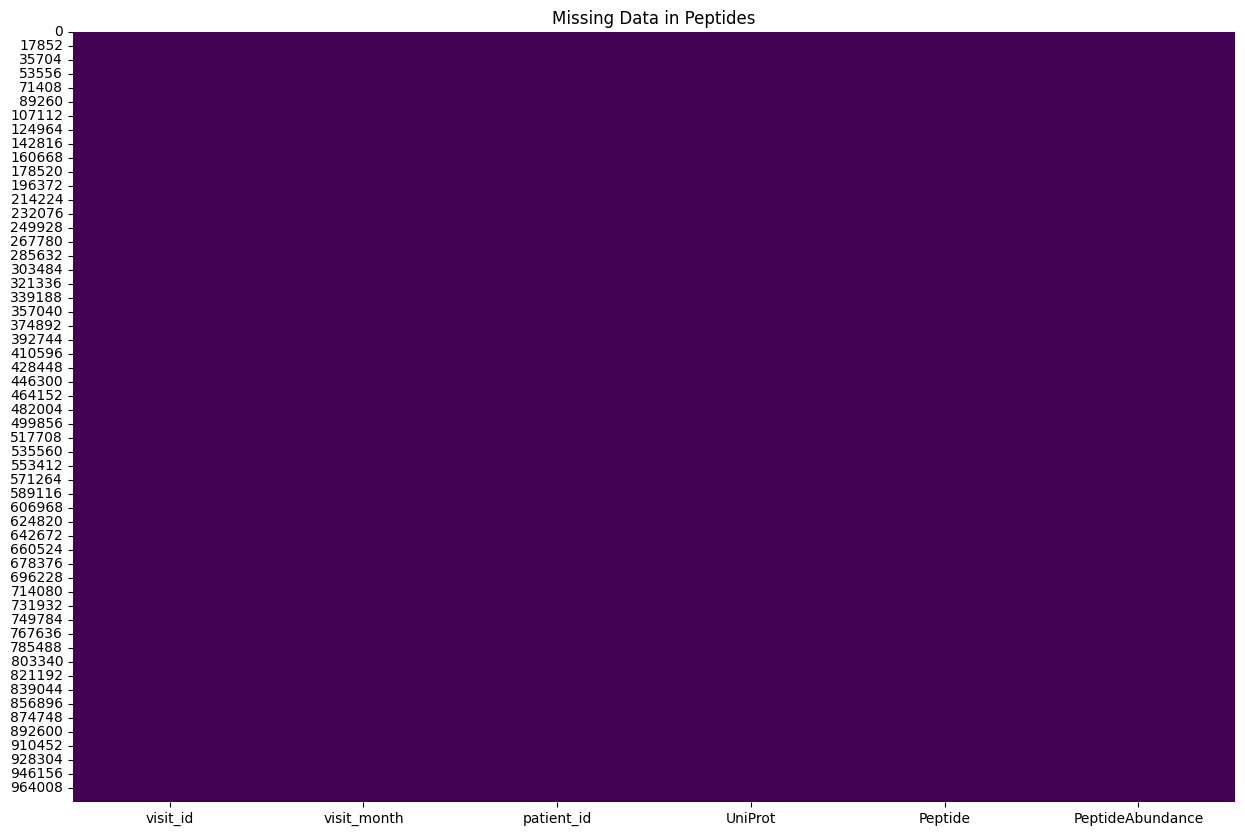

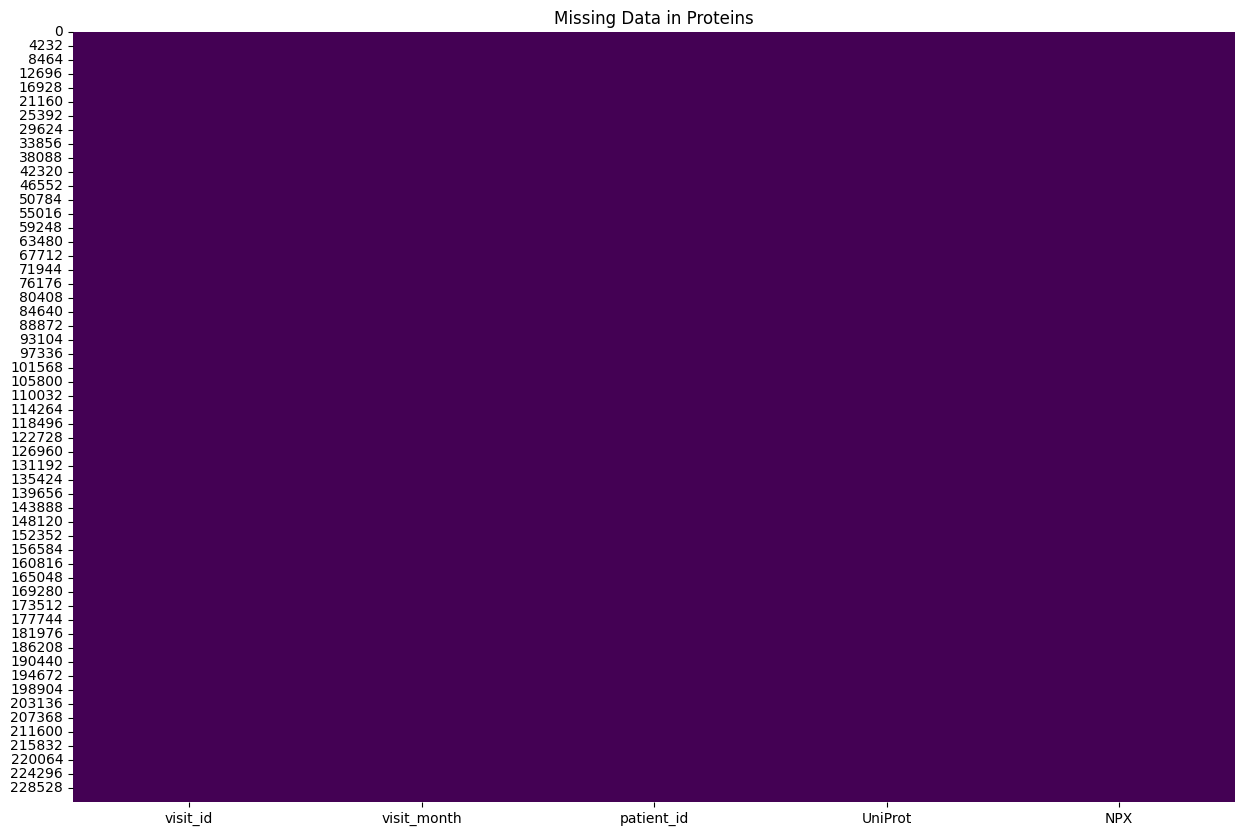

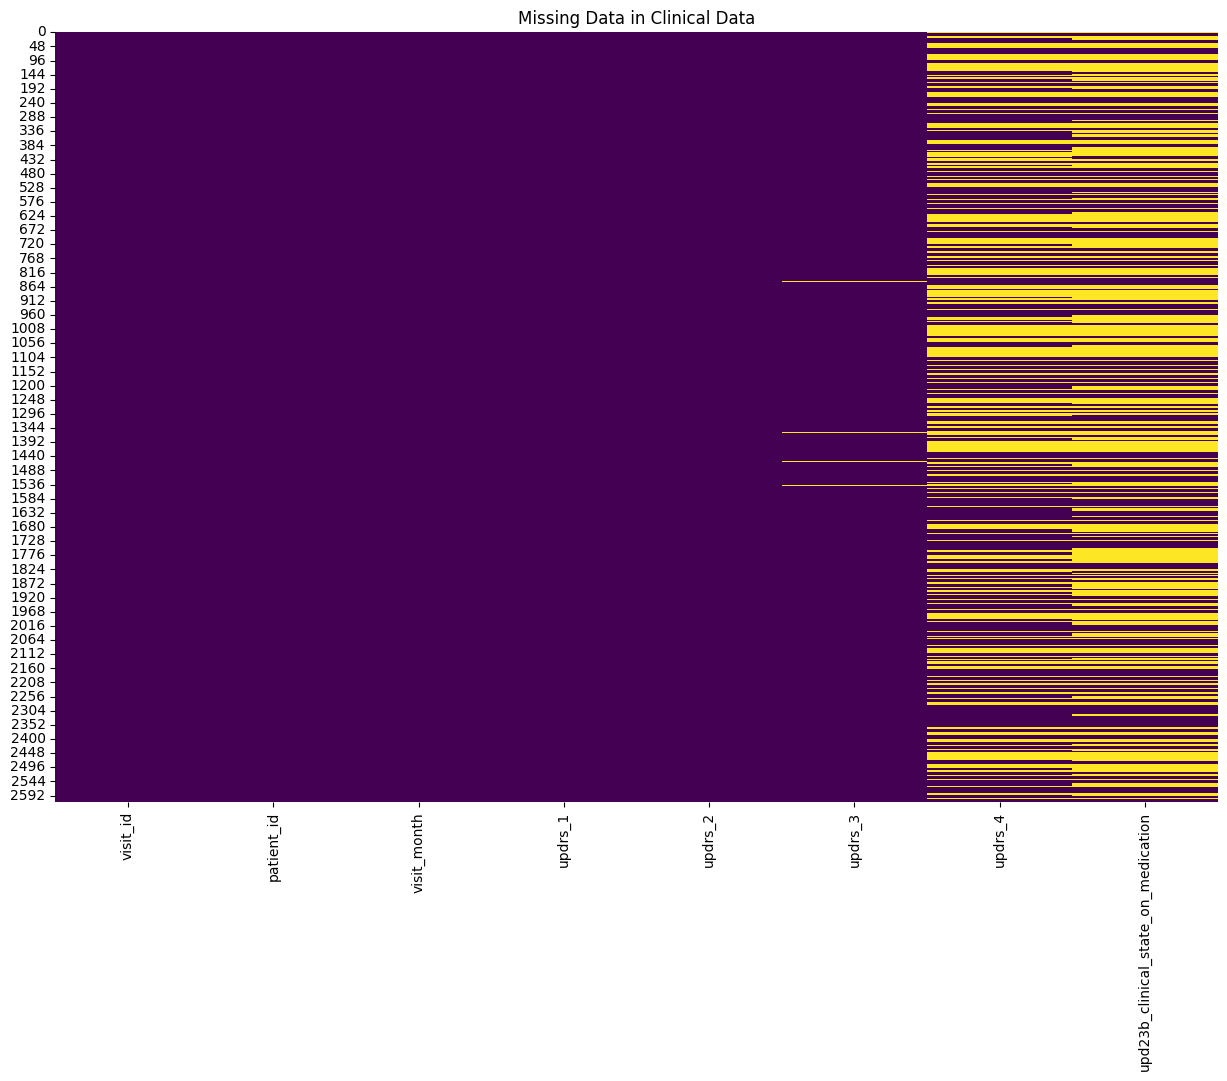

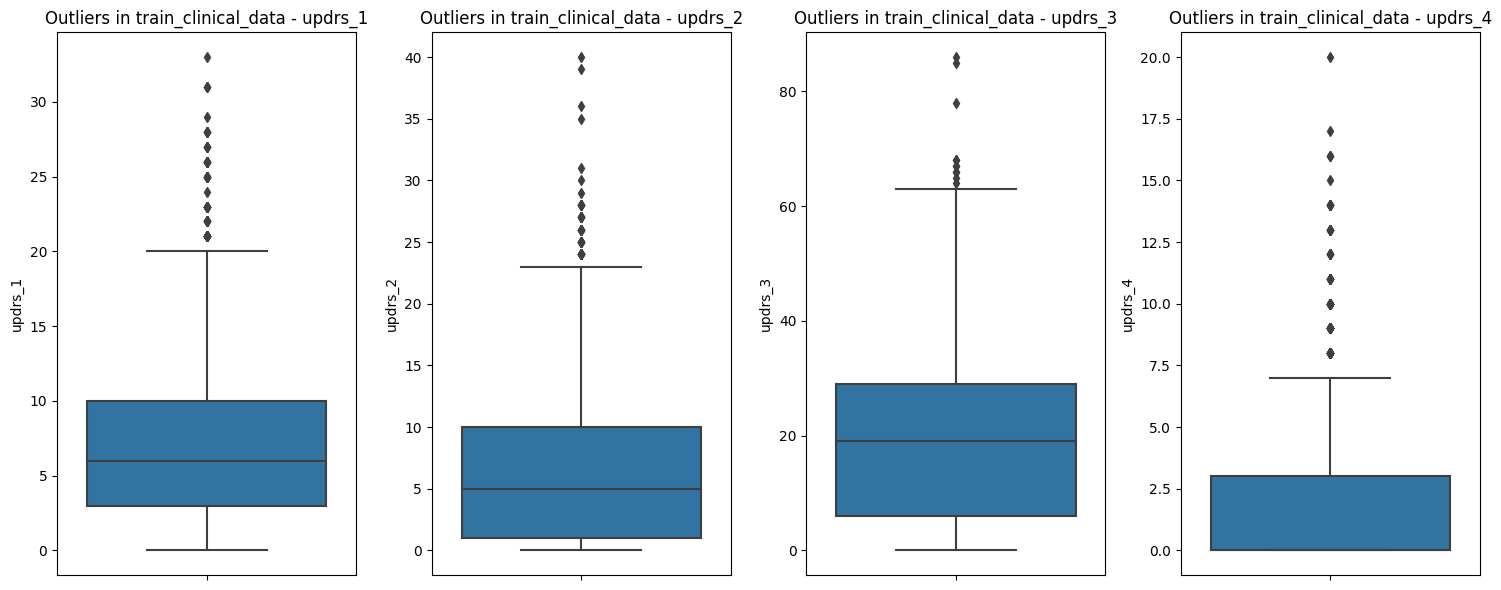

In [7]:
#Visualize Missing Data and data manipulation
import pandas as pd

def plot_missing_data_heatmap(df, title):
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title(title)
    plt.show()

plot_missing_data_heatmap(df_train_pep, 'Missing Data in Peptides')
plot_missing_data_heatmap(df_train_pro, 'Missing Data in Proteins')
plot_missing_data_heatmap(df_train_cli, 'Missing Data in Clinical Data')

#Check for outliers using boxplots
def plot_boxplots(df, columns, title):
    fig, axes = plt.subplots(1, len(columns), figsize=(15, 6))
    for idx, column in enumerate(columns):
        sns.boxplot(y=column, data=df, ax=axes[idx])
        axes[idx].set_title(f'{title} - {column}')
    plt.tight_layout()
    plt.show()

plot_boxplots(df_train_cli, ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], 'Outliers in train_clinical_data')

### Preprocessing

* Handle Missing values and outliers
* Encode Categorical features if necessary
* Normalize/standardize features, if necessary.
* Split dataset into training and test sets.

In [8]:
#Examine datasets for missing values
print("Missing Values in train_peptides: ")
print(df_train_pep.isnull().sum())

print("\nMissing Values in train_proteins: ")
print(df_train_pro.isnull().sum())

print("\nMissing Values in train_clinical_data: ")
print(df_train_cli.isnull().sum())

Missing Values in train_peptides: 
visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

Missing Values in train_proteins: 
visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

Missing Values in train_clinical_data: 
visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64


In [9]:
#Fill Missing Values in all datasets
df_train_cli['updrs_1'].fillna(df_train_cli['updrs_1'].median(), inplace=True)
df_train_cli['updrs_2'].fillna(df_train_cli['updrs_2'].median(), inplace=True)
df_train_cli['updrs_3'].fillna(df_train_cli['updrs_3'].median(), inplace=True)

# Fill missing values in updrs_4 with a constant value (-1)
df_train_cli['updrs_4'].fillna(-1, inplace=True)

# Fill missing values in upd23b_clinical_state_on_medication with the mode
mode_on_medication = df_train_cli['upd23b_clinical_state_on_medication'].mode().iloc[0]
df_train_cli['upd23b_clinical_state_on_medication'].fillna(mode_on_medication, inplace=True)

In [10]:
#Examine datasets for missing values
print("Missing Values in train_peptides: ")
print(df_train_pep.isnull().sum())

print("\nMissing Values in train_proteins: ")
print(df_train_pro.isnull().sum())

print("\nMissing Values in train_clinical_data: ")
print(df_train_cli.isnull().sum())

Missing Values in train_peptides: 
visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

Missing Values in train_proteins: 
visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

Missing Values in train_clinical_data: 
visit_id                               0
patient_id                             0
visit_month                            0
updrs_1                                0
updrs_2                                0
updrs_3                                0
updrs_4                                0
upd23b_clinical_state_on_medication    0
dtype: int64


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Aggregate peptide data by calculating the mean PeptideAbundance per patient and visit_month
peptide_agg = df_train_pep.groupby(['visit_id', 'visit_month'])['PeptideAbundance'].mean().reset_index()

# Merge dataframes on visit_id
merged_data = pd.merge(df_train_pro, peptide_agg, on=["visit_id", "visit_month"])
merged_data = pd.merge(merged_data, df_train_cli, on=["visit_id", "visit_month"])

# Add a unique patient_id column based on the visit_id (assuming each visit_id corresponds to a unique patient)
merged_data['patient_id'] = merged_data['visit_id'].apply(lambda x: x.split('_')[0])

# Pivot the data to have patients as rows and visit_month as columns
pivoted_data = merged_data.pivot_table(index="patient_id", columns="visit_month", values=["NPX", "PeptideAbundance", "updrs_1", "updrs_2", "updrs_3", "updrs_4"])

# Fill missing values with 0
pivoted_data.fillna(0, inplace=True)

# Scale the input data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivoted_data)

# Reshape the input data to be suitable for LSTM (samples, timesteps, features)
X = np.reshape(scaled_data, (scaled_data.shape[0], 1, scaled_data.shape[1]))

# Prepare the target variables
y = pivoted_data[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
7/7 [==============================] - 7s 234ms/step - loss: 43.7632 - val_loss: 65.1966
Epoch 2/50
7/7 [==============================] - 0s 26ms/step - loss: 43.5898 - val_loss: 64.8374
Epoch 3/50
7/7 [==============================] - 0s 21ms/step - loss: 43.2416 - val_loss: 64.0671
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 42.6062 - val_loss: 62.5076
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 41.2333 - val_loss: 59.9630
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 39.3634 - val_loss: 56.8213
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 37.2100 - val_loss: 53.9098
Epoch 8/50
7/7 [==============================] - 0s 21ms/step - loss: 35.4006 - val_loss: 51.6678
Epoch 9/50
7/7 [==============================] - 0s 19ms/step - loss: 34.1301 - val_loss: 50.1276
Epoch 10/50
7/7 [==============================] - 0s 19ms/step - loss: 33.4434 - val_loss: 49.0529
Epoch 11

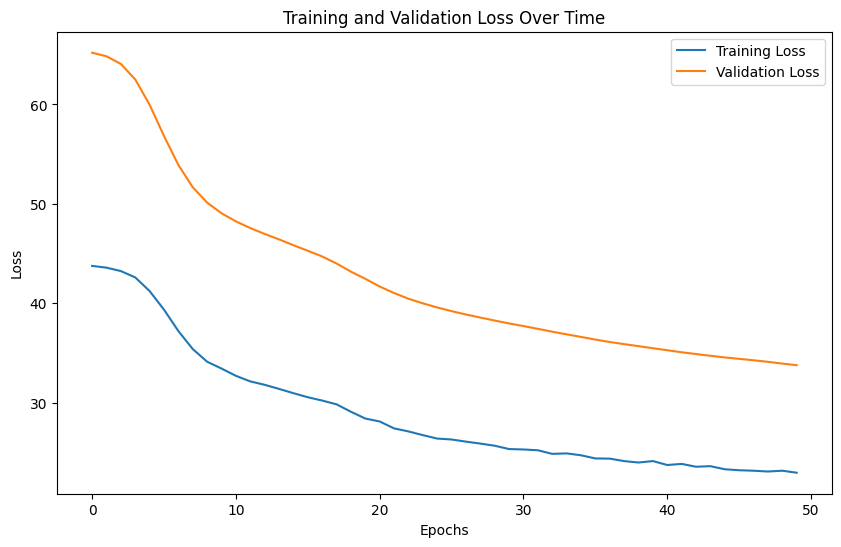

In [13]:
history = model.history.history

plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

### Evaluate model to calculate SMAPE

* Evaluate the model using the SMAPE metric.
* Compare the model's performance to that of a baseline model.

What is SMAPE?
Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. 


In [14]:
test_predictions = model.predict(X_test)

2/2 [==============================] - 1s 7ms/step


In [15]:
#Calculate SMAPE score
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_score = smape(y_test, test_predictions)
print(f"SMAPE Score: {smape_score}")

SMAPE Score: 171.38750246299225


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r2 = r2_score(y_test, test_predictions)

print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

RMSE: 5.812215021997093
R^2: 0.08886287383092224


### Creating Submission File

In [17]:
submission_predictions = model.predict(X_test)

predictions_ids = []
rating = []

for index, row in X_test.iterrows():
    patient_id = row['patient_id']
    visit_id = row['visit_id']

    for updrs in range(1, 5): # iterate through UPDRS 1 to 4
        for month in [0, 6, 12, 24]: # iterate through 0, 6, 12, and 24 months
            prediction_id = f"{patient_id}_{visit_id}_updrs_{updrs}_plus_{month}_months"
            rating = submission_predictions[index, updrs-1, month//6] # extract the corresponding prediction
            prediction_ids.append(prediction_id)
            ratings.append(rating)

submission_df = pd.DataFrame({'prediction_id': prediction_ids, 'rating': ratings})

2/2 [==============================] - 0s 5ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'